In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2023-12-27 08:52:10--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.75.9, 3.5.24.104, 52.216.43.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.75.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  45.8MB/s    in 6m 44s  

2023-12-27 08:58:54 (45.7 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2023-12-27 08:58:54--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.109.17, 54.231.204.9, 54.231.163.33, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.109.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[================

In [2]:
%%capture
!unzip coco_train2017.zip
!unzip coco_val2017.zip
!unzip coco_ann2017.zip

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset,Subset
from torchvision import transforms
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import tqdm
import torch.nn.functional as F
import warnings


In [ ]:
os.remove('/content/coco_train2017.zip')
os.remove('/content/coco_ann2017.zip')
os.remove('/content/coco_val2017.zip')


# Data Loader

In [4]:
class CocoClassificationDataset(Dataset):
    def __init__(self, root,annFile, transform=None):
        self.coco_dataset = CocoDetection(root, annFile, transform=transform)
        self.transform = transform
        self.num_classes=90

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, targets = self.coco_dataset[idx]

        if not targets:
            # Skip images without annotated objects
            return None, None

        # Assuming that the first annotation label is the class for classification
        label = targets[0]['category_id']

        # One-hot encode the label
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(label-1), num_classes=self.num_classes)

        return img, one_hot_label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize((0.5,), (0.5,))
    ])


In [5]:
train_path = '/content/train2017'
train_annFile = '/content//annotations/instances_train2017.json'

val_path = '/content/val2017'
val_annFile = '/content//annotations/instances_val2017.json'

train_dataset = CocoClassificationDataset(train_path,train_annFile, transform)
val_dataset = CocoClassificationDataset(val_path,val_annFile, transform)

train_size=5000    # Can't use all dataset because lack of System RAM in colab
train_dataset=Subset(train_dataset,range(train_size))
train_dataset = [entry for entry in train_dataset if entry[1] is not None]

val_size=1000    # Can't use all dataset because lack of System RAM in colab
val_dataset=Subset(val_dataset,range(val_size))
val_dataset = [entry for entry in val_dataset if entry[0] is not None]

print("Size dataset Train :",len(train_dataset))
print("Size dataset Validation :",len(val_dataset))



loading annotations into memory...
Done (t=18.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Size dataset Train : 4951
Size dataset Validation : 992


In [6]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


## Visualize data

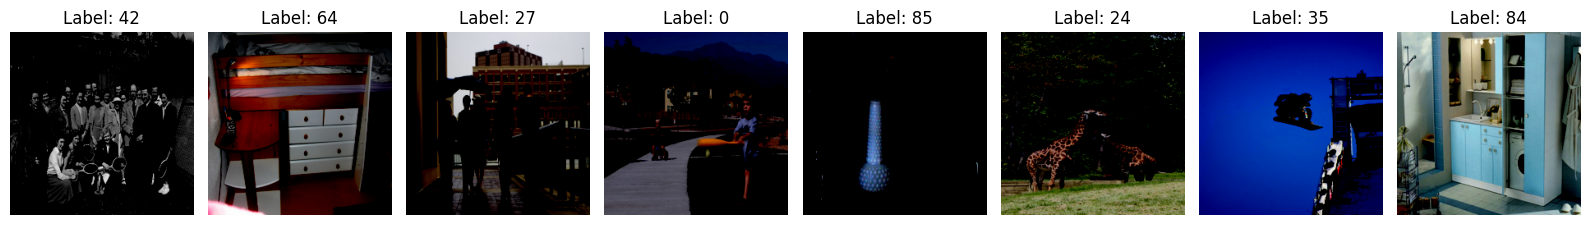

In [7]:
# Display sample images
(images, labels) = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(16, 5))
class_indices = torch.argmax(labels, dim=1)

for i in range(8):
    axes[i].imshow(torch.clamp(images[i],0,1).permute(1, 2, 0))
    axes[i].set_title(f"Label: {class_indices[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# Convolutional Networks



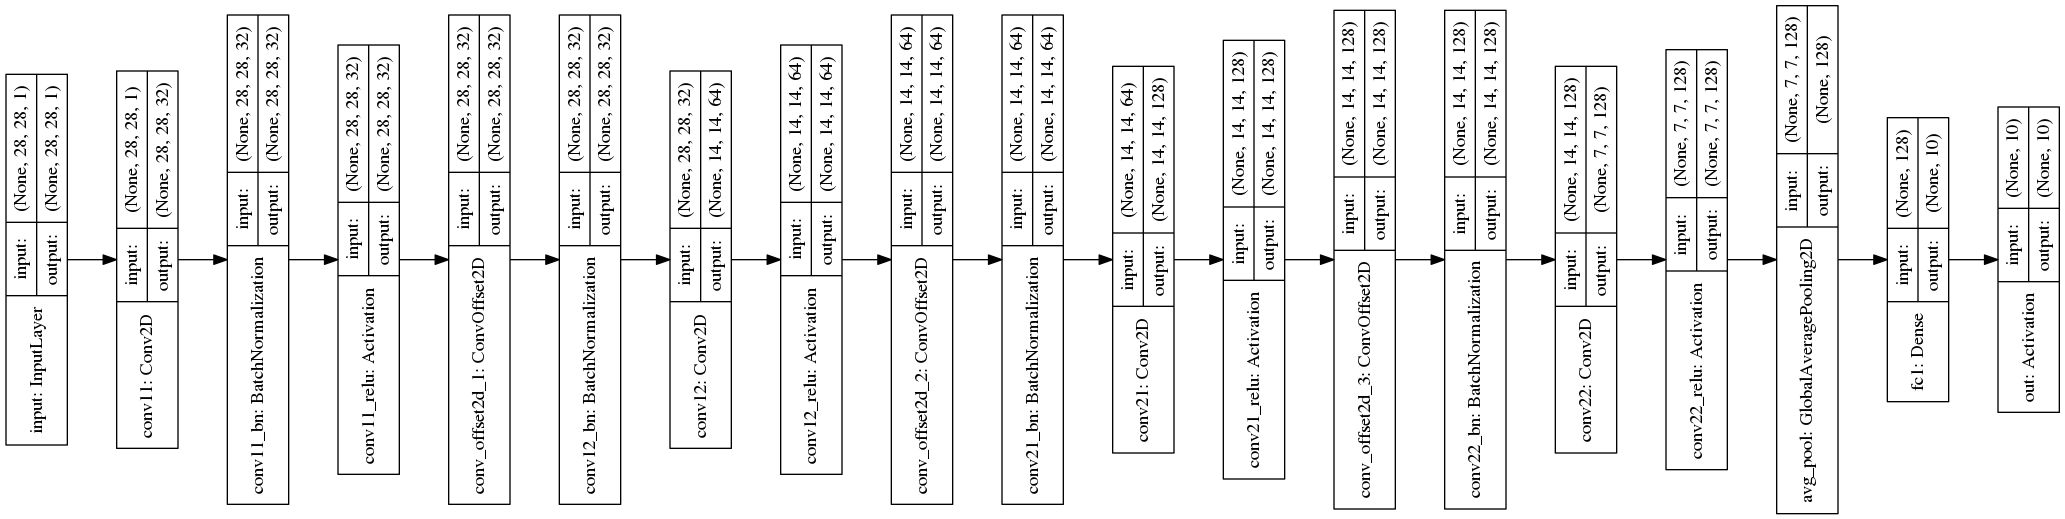

## Model

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()


        self.conv_1 = nn.Conv2d(3, 32, 3, padding=1)
        self.BN_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()

        self.conv_2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.BN_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()


        self.conv_3 = nn.Conv2d(64, 128, 3, padding= 1)
        self.BN_3 = nn.BatchNorm2d(128)
        self.relu_3 = nn.ReLU()


        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.BN_4 = nn.BatchNorm2d(128)
        self.relu_4 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(128, 90)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.BN_1(x)


        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.BN_2(x)

        x = self.conv_3(x)
        x = self.relu_3(x)
        x = self.BN_3(x)

        x = self.conv_4(x)
        x = self.relu_4(x)
        x = self.BN_4(x)

        x=self.pool(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)
        return x


## Traning

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
model = ConvNet().to(device)
num_epochs = 30

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training and validation loop
train_losses = []
train_acc = []
val_losses = []
val_acc = []

start = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    for inputs, labels in tqdm.tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, pred = torch.max(outputs, 1)
        _, target = torch.max(labels, 1)

        train_correct += (pred == target).sum().item()


    train_losses.append(train_loss / len(train_loader))
    train_acc.append(train_correct / len(train_loader.dataset))

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            val_loss += loss.item()

            _, pred = torch.max(outputs, 1)
            _, target = torch.max(labels, 1)

            val_correct += (pred == target).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy: {train_acc[-1]*100:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation accuracy: {val_acc[-1]*100:.2f}%")

end = time.time()


100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Epoch 1/30, Train Loss: 0.5506, Train accuracy: 12.93%, Validation Loss: 0.3004, Validation accuracy: 20.26%


100%|██████████| 78/78 [00:20<00:00,  3.72it/s]


Epoch 2/30, Train Loss: 0.1369, Train accuracy: 19.89%, Validation Loss: 0.0735, Validation accuracy: 21.17%


100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 3/30, Train Loss: 0.0611, Train accuracy: 20.18%, Validation Loss: 0.0543, Validation accuracy: 20.97%


100%|██████████| 78/78 [00:21<00:00,  3.55it/s]


Epoch 4/30, Train Loss: 0.0524, Train accuracy: 20.48%, Validation Loss: 0.0509, Validation accuracy: 21.17%


100%|██████████| 78/78 [00:22<00:00,  3.50it/s]


Epoch 5/30, Train Loss: 0.0496, Train accuracy: 20.70%, Validation Loss: 0.0494, Validation accuracy: 19.86%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 6/30, Train Loss: 0.0481, Train accuracy: 20.90%, Validation Loss: 0.0477, Validation accuracy: 21.67%


100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 7/30, Train Loss: 0.0472, Train accuracy: 21.43%, Validation Loss: 0.0478, Validation accuracy: 22.18%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 8/30, Train Loss: 0.0464, Train accuracy: 21.51%, Validation Loss: 0.0468, Validation accuracy: 21.98%


100%|██████████| 78/78 [00:22<00:00,  3.51it/s]


Epoch 9/30, Train Loss: 0.0457, Train accuracy: 22.04%, Validation Loss: 0.0465, Validation accuracy: 23.29%


100%|██████████| 78/78 [00:22<00:00,  3.49it/s]


Epoch 10/30, Train Loss: 0.0451, Train accuracy: 22.50%, Validation Loss: 0.0460, Validation accuracy: 23.39%


100%|██████████| 78/78 [00:21<00:00,  3.55it/s]


Epoch 11/30, Train Loss: 0.0447, Train accuracy: 23.19%, Validation Loss: 0.0457, Validation accuracy: 23.99%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 12/30, Train Loss: 0.0443, Train accuracy: 22.99%, Validation Loss: 0.0452, Validation accuracy: 24.29%


100%|██████████| 78/78 [00:22<00:00,  3.53it/s]


Epoch 13/30, Train Loss: 0.0439, Train accuracy: 23.59%, Validation Loss: 0.0453, Validation accuracy: 24.50%


100%|██████████| 78/78 [00:22<00:00,  3.53it/s]


Epoch 14/30, Train Loss: 0.0435, Train accuracy: 24.12%, Validation Loss: 0.0446, Validation accuracy: 24.09%


100%|██████████| 78/78 [00:22<00:00,  3.53it/s]


Epoch 15/30, Train Loss: 0.0432, Train accuracy: 24.76%, Validation Loss: 0.0451, Validation accuracy: 24.29%


100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 16/30, Train Loss: 0.0429, Train accuracy: 24.98%, Validation Loss: 0.0444, Validation accuracy: 24.70%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 17/30, Train Loss: 0.0425, Train accuracy: 25.13%, Validation Loss: 0.0442, Validation accuracy: 24.80%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 18/30, Train Loss: 0.0422, Train accuracy: 25.91%, Validation Loss: 0.0446, Validation accuracy: 25.30%


100%|██████████| 78/78 [00:22<00:00,  3.53it/s]


Epoch 19/30, Train Loss: 0.0419, Train accuracy: 26.66%, Validation Loss: 0.0442, Validation accuracy: 25.71%


100%|██████████| 78/78 [00:21<00:00,  3.55it/s]


Epoch 20/30, Train Loss: 0.0416, Train accuracy: 26.48%, Validation Loss: 0.0447, Validation accuracy: 24.09%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 21/30, Train Loss: 0.0413, Train accuracy: 27.65%, Validation Loss: 0.0443, Validation accuracy: 26.11%


100%|██████████| 78/78 [00:21<00:00,  3.55it/s]


Epoch 22/30, Train Loss: 0.0409, Train accuracy: 28.28%, Validation Loss: 0.0439, Validation accuracy: 25.20%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 23/30, Train Loss: 0.0407, Train accuracy: 28.50%, Validation Loss: 0.0437, Validation accuracy: 25.50%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 24/30, Train Loss: 0.0404, Train accuracy: 29.15%, Validation Loss: 0.0439, Validation accuracy: 26.61%


100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 25/30, Train Loss: 0.0402, Train accuracy: 29.67%, Validation Loss: 0.0451, Validation accuracy: 25.60%


100%|██████████| 78/78 [00:21<00:00,  3.57it/s]


Epoch 26/30, Train Loss: 0.0398, Train accuracy: 30.38%, Validation Loss: 0.0435, Validation accuracy: 26.51%


100%|██████████| 78/78 [00:22<00:00,  3.54it/s]


Epoch 27/30, Train Loss: 0.0395, Train accuracy: 30.72%, Validation Loss: 0.0441, Validation accuracy: 27.92%


100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Epoch 28/30, Train Loss: 0.0392, Train accuracy: 30.72%, Validation Loss: 0.0437, Validation accuracy: 26.92%


100%|██████████| 78/78 [00:21<00:00,  3.55it/s]


Epoch 29/30, Train Loss: 0.0390, Train accuracy: 31.13%, Validation Loss: 0.0432, Validation accuracy: 27.92%


100%|██████████| 78/78 [00:21<00:00,  3.57it/s]


Epoch 30/30, Train Loss: 0.0386, Train accuracy: 32.11%, Validation Loss: 0.0437, Validation accuracy: 27.52%


The low accuracy is mainly because the COCO dataset has a whopping 90 different classes, and we need a ton of data to train effectively. The problem is, platforms like Colab have memory limits, so we can't gather enough data for solid training

In [11]:
time_conv=end-start
print(f"traning Time: {time_conv:.2f} seconds")

traning Time: 708.18 seconds


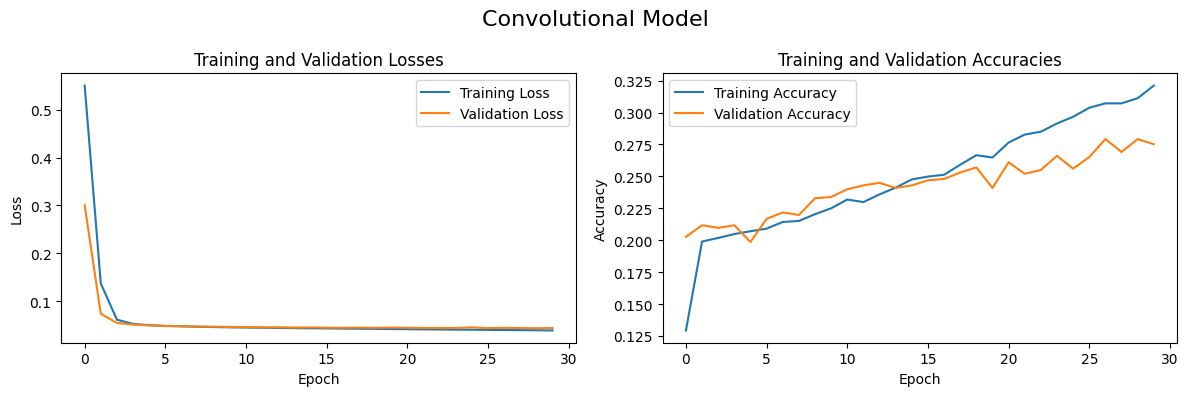

In [12]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Convolutional Model', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Deformable Convolutional Networks

## Deformable Convolution

In [13]:
class DeformableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DeformableConv2D, self).__init__()
        self.kernel_size = kernel_size  # Save kernel size as instance variable

        # Standard convolutional layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

        # Offset and mask generation layers
        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size, stride=stride, padding=padding)
        self.mask_conv = nn.Conv2d(in_channels,out_channels , kernel_size, stride=stride, padding=padding)

    def forward(self, x):

        # Generate offset and mask
        offset = self.offset_conv(x)
        mask = 0.2*torch.tanh(self.mask_conv(x))

        # Deformable convolution operation
        output = self.deformable_convolution(x, offset, mask)

        return output

    def deformable_convolution(self, input, offset, mask):
        batch_size, channels, height, width = input.size()

        h_range = torch.arange(0, height, dtype=torch.float32, device=input.device)
        w_range = torch.arange(0, width, dtype=torch.float32, device=input.device)
        warnings.filterwarnings("ignore", category=UserWarning, module="torch.functional")
        h_grid, w_grid = torch.meshgrid(h_range, w_range)

        # Normalize coordinates to [-1, 1]
        h_grid=(2.0*h_grid/(height-1))-1.0
        w_grid=(2.0*w_grid/(width-1))-1.0

        grid = torch.stack((h_grid, w_grid), dim=-1)   # Grid shape: (h, w, 2)
        #offset=self.mj(offset)
        #offset=offset.permute(0, 2, 3, 1)
        #offset=offset.reshape(batch_size,height,width,2,self.kernel_size*self.kernel_size).sum(-1)


        grid = grid.unsqueeze(0).expand(batch_size, -1, -1, -1)  # Grid shape: (batch_size, h, w, 2)
        #print("grid",grid.shape)
        #print("off",offfset.shape)
        #grid = grid + offset  # Apply offsets to grid

        sampled_feature_map = F.grid_sample(input, grid, mode='bilinear', align_corners=False)


        sampled_feature_map=self.conv(sampled_feature_map)

        # Apply mask
        output = sampled_feature_map*mask

        return output




## Model

In [14]:
class DEConvNet(nn.Module):
    def __init__(self):
        super(DEConvNet, self).__init__()


        self.conv_1 = DeformableConv2D(3, 32, 3, padding=1)
        self.BN_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()

        self.conv_2 = DeformableConv2D(32, 64, 3, padding=1, stride=2)
        self.BN_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()


        self.conv_3 = DeformableConv2D(64, 128, 3, padding= 1)
        self.BN_3 = nn.BatchNorm2d(128)
        self.relu_3 = nn.ReLU()


        self.conv_4 = DeformableConv2D(128, 128, 3, padding=1, stride=2)
        self.BN_4 = nn.BatchNorm2d(128)
        self.relu_4 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(128, 90)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.BN_1(x)


        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.BN_2(x)

        x = self.conv_3(x)
        x = self.relu_3(x)
        x = self.BN_3(x)

        x = self.conv_4(x)
        x = self.relu_4(x)
        x = self.BN_4(x)

        x=self.pool(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)

        return x


## Training

In [15]:
model = DEConvNet().to(device)
num_epochs = 30

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training and validation loop
train_losses_deconv = []
train_acc_deconv = []
val_losses_deconv = []
val_acc_deconv = []

start_deconv = time.time()

for epoch in range(num_epochs):
    # Training phase

    model.train()
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    for inputs, labels in tqdm.tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, pred = torch.max(outputs, 1)
        _, target = torch.max(labels, 1)

        train_correct += (pred == target).sum().item()



    train_losses_deconv.append(train_loss / len(train_loader))
    train_acc_deconv.append(train_correct / len(train_loader.dataset))

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            val_loss += loss.item()

            _, pred = torch.max(outputs, 1)
            _, target = torch.max(labels, 1)

            val_correct += (pred == target).sum().item()

    val_losses_deconv.append(val_loss / len(val_loader))
    val_acc_deconv.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses_deconv[-1]:.4f}, Train accuracy: {train_acc_deconv[-1]*100:.2f}%, Validation Loss: {val_losses_deconv[-1]:.4f}, Validation accuracy: {val_acc_deconv[-1]*100:.2f}%")

end_deconv=time.time()


100%|██████████| 78/78 [00:56<00:00,  1.37it/s]


Epoch 1/30, Train Loss: 0.5529, Train accuracy: 9.31%, Validation Loss: 0.2909, Validation accuracy: 20.56%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 2/30, Train Loss: 0.1372, Train accuracy: 19.77%, Validation Loss: 0.0781, Validation accuracy: 20.67%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 3/30, Train Loss: 0.0623, Train accuracy: 19.81%, Validation Loss: 0.0558, Validation accuracy: 20.56%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 4/30, Train Loss: 0.0536, Train accuracy: 20.04%, Validation Loss: 0.0526, Validation accuracy: 20.26%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 5/30, Train Loss: 0.0508, Train accuracy: 19.83%, Validation Loss: 0.0505, Validation accuracy: 20.56%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 6/30, Train Loss: 0.0492, Train accuracy: 20.20%, Validation Loss: 0.0491, Validation accuracy: 21.67%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 7/30, Train Loss: 0.0482, Train accuracy: 20.68%, Validation Loss: 0.0492, Validation accuracy: 20.87%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 8/30, Train Loss: 0.0474, Train accuracy: 20.93%, Validation Loss: 0.0484, Validation accuracy: 20.97%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 9/30, Train Loss: 0.0467, Train accuracy: 21.77%, Validation Loss: 0.0474, Validation accuracy: 22.78%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 10/30, Train Loss: 0.0461, Train accuracy: 22.06%, Validation Loss: 0.0468, Validation accuracy: 22.08%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 11/30, Train Loss: 0.0457, Train accuracy: 22.58%, Validation Loss: 0.0474, Validation accuracy: 21.67%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 12/30, Train Loss: 0.0453, Train accuracy: 22.70%, Validation Loss: 0.0464, Validation accuracy: 22.38%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 13/30, Train Loss: 0.0448, Train accuracy: 23.23%, Validation Loss: 0.0465, Validation accuracy: 21.98%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 14/30, Train Loss: 0.0442, Train accuracy: 23.13%, Validation Loss: 0.0461, Validation accuracy: 23.29%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 15/30, Train Loss: 0.0436, Train accuracy: 24.42%, Validation Loss: 0.0458, Validation accuracy: 23.29%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 16/30, Train Loss: 0.0433, Train accuracy: 24.78%, Validation Loss: 0.0457, Validation accuracy: 22.98%


100%|██████████| 78/78 [00:56<00:00,  1.37it/s]


Epoch 17/30, Train Loss: 0.0428, Train accuracy: 24.84%, Validation Loss: 0.0459, Validation accuracy: 23.89%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 18/30, Train Loss: 0.0424, Train accuracy: 25.33%, Validation Loss: 0.0461, Validation accuracy: 23.39%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 19/30, Train Loss: 0.0419, Train accuracy: 26.78%, Validation Loss: 0.0455, Validation accuracy: 23.29%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 20/30, Train Loss: 0.0416, Train accuracy: 27.49%, Validation Loss: 0.0454, Validation accuracy: 23.59%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 21/30, Train Loss: 0.0410, Train accuracy: 28.58%, Validation Loss: 0.0452, Validation accuracy: 23.99%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 22/30, Train Loss: 0.0406, Train accuracy: 29.23%, Validation Loss: 0.0458, Validation accuracy: 23.79%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 23/30, Train Loss: 0.0405, Train accuracy: 29.21%, Validation Loss: 0.0455, Validation accuracy: 24.50%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 24/30, Train Loss: 0.0400, Train accuracy: 30.24%, Validation Loss: 0.0456, Validation accuracy: 23.19%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 25/30, Train Loss: 0.0394, Train accuracy: 31.47%, Validation Loss: 0.0452, Validation accuracy: 24.09%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 26/30, Train Loss: 0.0390, Train accuracy: 31.37%, Validation Loss: 0.0453, Validation accuracy: 24.90%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 27/30, Train Loss: 0.0386, Train accuracy: 32.26%, Validation Loss: 0.0452, Validation accuracy: 23.69%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 28/30, Train Loss: 0.0383, Train accuracy: 33.08%, Validation Loss: 0.0459, Validation accuracy: 22.98%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 29/30, Train Loss: 0.0377, Train accuracy: 34.17%, Validation Loss: 0.0460, Validation accuracy: 23.39%


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


Epoch 30/30, Train Loss: 0.0375, Train accuracy: 34.30%, Validation Loss: 0.0461, Validation accuracy: 22.88%


In [16]:
time_deconv=end_deconv-start_deconv
print(f"traning Time (DEConv): {time_deconv:.2f} seconds")

traning Time (DEConv): 1813.83 seconds


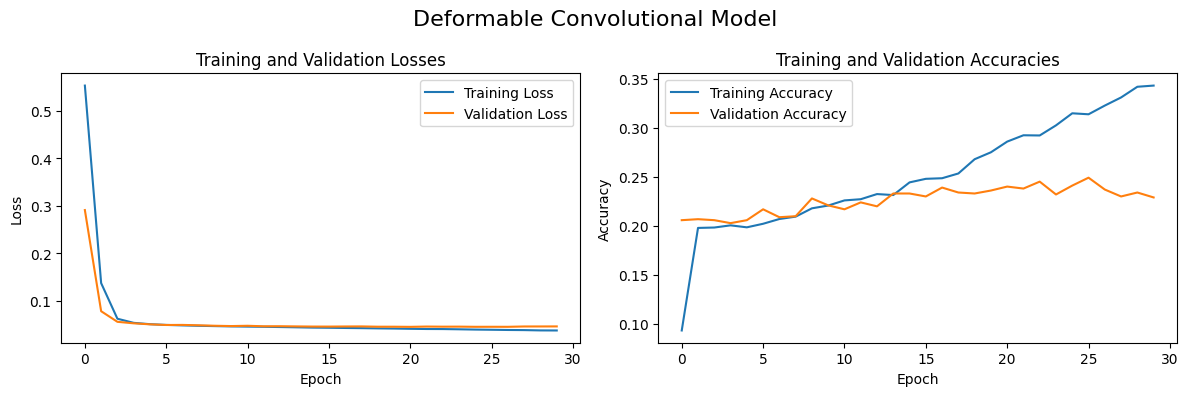

In [17]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Deformable Convolutional Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_losses_deconv, label='Training Loss')
plt.plot(val_losses_deconv, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc_deconv, label='Training Accuracy')
plt.plot(val_acc_deconv, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Comparison of two models

## Training Time

In [18]:
print(f"traning Time (ConV): {time_conv:.2f} seconds")
print(f"traning Time (DEConv): {time_deconv:.2f} seconds")

traning Time (ConV): 708.18 seconds
traning Time (DEConv): 1813.83 seconds


## Traning and Validation

I think we have enough data, and using deformable convolution could make our accuracy even better, like how it works well with the MNIST dataset.

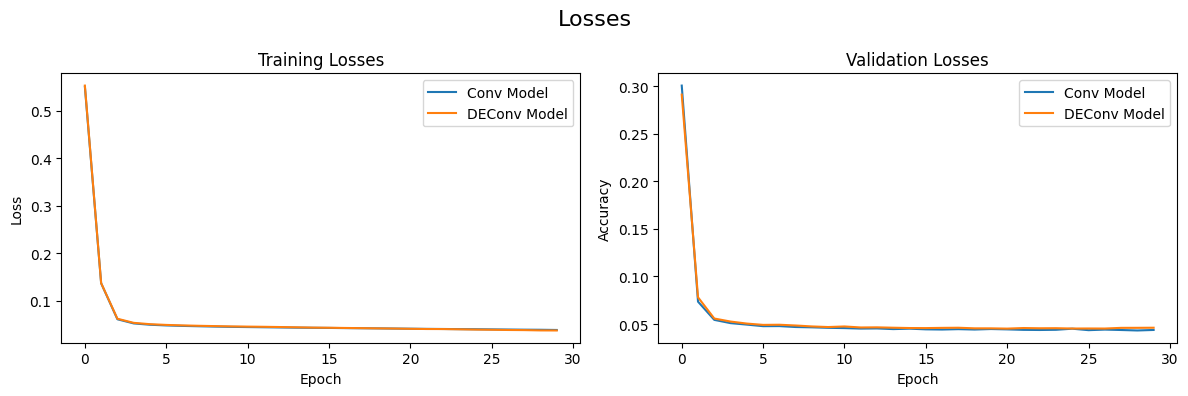

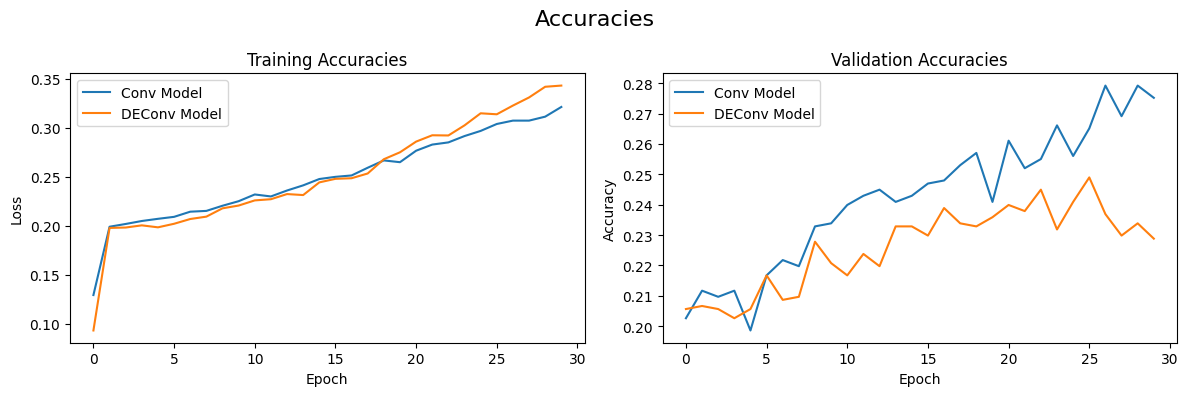

In [19]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Losses', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Conv Model')
plt.plot(train_losses_deconv, label='DEConv Model')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Conv Model')
plt.plot(val_losses_deconv, label='DEConv Model')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plotting accuracies
plt.figure(figsize=(12, 4))
plt.suptitle('Accuracies', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Conv Model')
plt.plot(train_acc_deconv, label='DEConv Model')
plt.title('Training Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Conv Model')
plt.plot(val_acc_deconv, label='DEConv Model')
plt.title('Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



### (a) Difference between Regular Convolutional Networks and Deformable Convolution Networks in terms of Sampling Grid:

Deformable Convolution Networks utilize a more flexible sampling grid to better adapt to geometric changes in images. In regular convolution, the sampling grid is fixed and always centered on a specific point in the image. However, in Deformable Convolution, this grid is allowed to interact with different points in the image, providing adaptability to various geometric changes.

### (b) How Deformable Convolution Networks Introduce Flexibility in Geometric Transformations:

Deformable Convolution Networks introduce flexibility in geometric transformations by incorporating an additional layer into the convolutional architecture known as "Deformable Convolution Layer" or "Convolution Deformable." This layer, using a flexible sampling grid, allows the model to better align with various geometric changes in the image, providing improved compatibility with different transformations.

### (c) Why Regular Convolutional Networks Encounter Serious Issues with Highly Spatially Variant Images:

Regular Convolutional Networks may face serious issues when dealing with images that have significant spatial changes or rotations. These issues include the loss of important information in geometric transformations, difficulties in recognizing objects in different positions, and the loss of spatial relationship information between image components.

### (d) How Offsets in Deformable Convolution are Computed:

Offsets in Deformable Convolution are calculated using a specific layer called the "Deformable Convolution Layer." This layer employs a spatial predictor for each pixel to provide a flexible sampling grid to the model. These flexible grid details determine the displacement (offset) concerning the regular centered position for each point in the image. These offset details enable the model to adapt to various geometric changes in the image.
